<h2><u>Self Case Study 2 :</u>  AI2 Reasoning Challenge (ARC) 2018(Question Answering Model) </b></h2>

<h2>Business problem</h2>

<p>A new dataset of 7,787 genuine grade-school level, multiple-choice science questions, assembled to encourage research in advanced question-answering. The dataset is partitioned into a Challenge Set and an Easy Set, where the former contains only questions answered incorrectly by both a retrieval-based algorithm and a word co-occurrence algorithm. They have also given us a corpus of over 14 million science sentences relevant to the task, and an implementation of three neural baseline models for this dataset. They posed ARC as a challenge to the community.
</p>

<p>What we need to do : We have questions given and  on the based of these question and 14 million science sentences(using it is optional) we need to find the valid answer.</p>

<img src = "https://blog.frase.io/wp-content/uploads/2019/03/question-answering-website-1200x742.png"></img>


<p><b><u>What we achieve with this case study</u> : In this Case study we will be getting the correct answer from the multiple choice answers</p>

<h2>Data Given</h2>

<h4>We have given 7,787 questions and out of which 2950 are challenign questions and 5197 are Easy questions whcich are easy to predict the answers</h4>
<pre>1) Challening Dataset</pre>
<pre>2) Easy Dataset</pre>

<pre>3) They have also given us <b>14 million</b> dataset which is optional to use or not it's our decision : </pre>
<p><center>Data Corpus</center></p>
<pre><i><u>Large international companies are involved in bauxite, iron ore, diamond, and gold mining operations.Paleoceanography, 8(2): 193-208.Of course, for many in the media, “hydrogen sulphide delivery helps prevent disease damage in cells in certain disease models” will always be trumped by “farts cure cancer” when it comes to headlines.The same problems apply with wolf-domestic dog hybrids.taking stock of delightful days</u></i></pre>
<pre>4) They have given us one research paper in which they have tried diffeent models to get the result but didn't get the success in the challengin set : https://arxiv.org/pdf/1803.05457.pdf</pre>

<h2>Problem Analysis.</h2>
    <pre>1) <b>It is a question anwering problem which contain multiple choice questions.</pre>
    <pre>2)<b> Problem Interpretibility</b> :After running some models, we will be seeing why my model predicts that answer as cprrect answer by looking  at the answer and the question asked and try to see the link between them. </pre>
    <pre>3) <b>Measurement criterian used</b>: i Will have to the bring the score near to the score they get in research paper </pre>
<img src = "https://i.imgur.com/4EzL5yC.png"></img>
 




<h3>1. EDA</h3>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
from tqdm.notebook import tqdm
import torch
import seaborn as sns
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import linecache

In [2]:
def Conv_Json_to_Dataframe(file_object):
    jsonList = []
    id_values = []
    answer_values = []
    stem_values = []
    choices_all = []
    option_1 = []
    option_2 = []
    option_3 = []
    option_4 = []
    option_5 = []
    # Loading the Json file line by line and appending in a list jsonList.
    for jsonObj in file_object:
        jsonDict = json.loads(jsonObj)
        jsonList.append(jsonDict)
        
     # Fetching each key and it;s value and inserting these vlaues in particular list   
    for Question_Answer in tqdm(jsonList):
        keys = Question_Answer.keys()
        id_values.append(Question_Answer['id'])
        answer_values.append(Question_Answer['answerKey'])
        stem_values.append(Question_Answer['question']['stem'])
        choices_all.append(Question_Answer['question']['choices'])

    list_of_options = []
    for choices in choices_all:
        numberofoptions = len(choices)
        check = []
        for text_dict in choices:
            check.append(text_dict['text'])
        # For empty options i am inserting NaN and i know maximum number of options present in file is 5
        for i in range(5-numberofoptions):
            check.append(np.NAN)
        list_of_options.append(check)

    # creating list for each column    
    option_1 = [i[0] for i in list_of_options]
    option_2 = [i[1] for i in list_of_options]
    option_3 = [i[2] for i in list_of_options]
    option_4 = [i[3] for i in list_of_options]
    option_5 = [i[4] for i in list_of_options]
    # Creating a dataframe for Answers and question
    return pd.DataFrame(dict({'id': id_values,'AnswerKey' : answer_values,'question' : stem_values,'A' : option_1\
                     ,'B' : option_2,'C' : option_3,'D' : option_4,'E' : option_5 }))        


In [3]:
# Loading Challenge Dataframe
print("Loading challenge data")
print("\n")
with open('ARC-Challenge/ARC-Challenge-Dev.jsonl') as f:
    Dev_multiple_answers_challenge = Conv_Json_to_Dataframe(f)      
f.close()
with open('ARC-Challenge/ARC-Challenge-Test.jsonl') as f:
    Test_multiple_answers_challenge = Conv_Json_to_Dataframe(f)      
f.close()
with open('ARC-Challenge/ARC-Challenge-Train.jsonl') as f:
    Train_multiple_answers_challenge = Conv_Json_to_Dataframe(f)      
f.close()

Dev_multiple_main_challenge = pd.read_csv('ARC-Challenge/ARC-Challenge-Dev.csv')
Test_multiple_main_challenge = pd.read_csv('ARC-Challenge/ARC-Challenge-Test.csv')
Train_multiple_main_challenge = pd.read_csv('ARC-Challenge/ARC-Challenge-Train.csv')

# Loading Easy Dataframe
print("Loading Easy data")
print("\n")
with open('ARC-Easy/ARC-Easy-Dev.jsonl') as f:
    Dev_multiple_answers_easy = Conv_Json_to_Dataframe(f)      
f.close()
with open('ARC-Easy/ARC-Easy-Test.jsonl') as f:
    Test_multiple_answers_easy = Conv_Json_to_Dataframe(f)      
f.close()
with open('ARC-Easy/ARC-Easy-Train.jsonl',encoding="utf8") as f:
    Train_multiple_answers_easy = Conv_Json_to_Dataframe(f)      
f.close()

Dev_multiple_main_easy = pd.read_csv('ARC-Easy/ARC-Easy-Dev.csv')
Test_multiple_main_easy = pd.read_csv('ARC-Easy/ARC-Easy-Test.csv')
Train_multiple_main_easy = pd.read_csv('ARC-Easy/ARC-Easy-Train.csv')

Loading challenge data





Loading Easy data




In [4]:
Train_multiple_main_easy = Dev_multiple_main_easy.join(Train_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)
Test_multiple_main_easy = Test_multiple_main_easy.join(Test_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)
Dev_multiple_main_easy = Dev_multiple_main_easy.join(Dev_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)

Train_multiple_main_challenge = Train_multiple_main_challenge.join(Train_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)
Test_multiple_main_challenge = Test_multiple_main_challenge.join(Test_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)
Dev_multiple_main_challenge = Dev_multiple_main_challenge.join(Dev_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)


In [245]:
Dev_multiple_main_easy.head(2)

,questionID,originalQuestionID,totalPossiblePoint,AnswerKey,isMultipleChoiceQuestion,includesDiagram,examName,schoolGrade,year,question,subject,category,A,B,C,D,E
0,MCAS_2000_4_6,6,1,A,1,0,MCAS,4,2000,Which technology was developed most recently? ...,NaN,Dev,cellular telephone,television,refrigerator,airplane,NaN
1,Mercury_7057260,7057260,1,C,1,0,Mercury,8,2015,A student hypothesizes that algae are producer...,NaN,Dev,Do algae consume other organisms?,Which organisms consume algae?,Do algae use sunlight to make food?,Could an ecosystem survive without algae?,NaN


<h4>14 Million !! Corpous for these questions</h4>

In [14]:
from random import seed
from random import randint
# seed random number generator
Corpous = []
def recursive_sampling(sample_size_corpous,sample_size_we_want):
    seed(randint(0,100))
    random_sample = []
    count = 0
    for _ in tqdm(range(sample_size_we_want)):# random sampling random one lakh sentences from corpous
        random_sample.append(randint(0, sample_size_corpous))
        random_sample = sorted(random_sample)
        
    with open("ARC_Corpus.txt",encoding='utf-8') as f:
        for _ in tqdm(range(sample_size_corpous)):
            count+=1
            if count in random_sample:
                Corpous.append(f.readline())
        if len(Corpous) <=sample_size_we_want:
            recursive_sampling(sample_size_corpous,sample_size_we_want-len(Corpous))
    return Corpous       
Sampled_Corpous_data = recursive_sampling(1000000,10000)            

In [262]:
# FEtching the text in the corpoius given to us

with open("ARC_Corpus.txt",encoding='utf-8') as f:
    count = 0
    for i in range(15):
        if(count<=15):
            lines = f.readline()
            print(lines)
        else:
            break
        count+=1    

Large international companies are involved in bauxite, iron ore, diamond, and gold mining operations.

Paleoceanography, 8(2): 193-208.

Of course, for many in the media, “hydrogen sulphide delivery helps prevent disease damage in cells in certain disease models” will always be trumped by “farts cure cancer” when it comes to headlines.

The same problems apply with wolf-domestic dog hybrids.

taking stock of delightful days

The an- tlu-opologist and the ethnologist find in trop- ical America some of the most complicated and interesting problems of research.

ORDER ODONATA (Damselflies and Dragonflies) Diagnosis: large, to over three inches long; four wings, transparent and membranous, held vertically (damselflies) or laterally (dragonflies) at rest; chew- ing mouth parts, tooth-like; nymphs aquatic, feeding on mosquito larvae to small fish; adults terrestrial, feeding on other insects (Figure 14.27).

until they institute such safeguards and assurances of chaste maidenhood as characte

In [193]:
print("Shape of Test_multiple_main_challenge", Test_multiple_main_challenge.shape)
Test_multiple_main_challenge.describe()

Shape of Test_multiple_main_challenge (1172, 12)


,totalPossiblePoint,isMultipleChoiceQuestion,includesDiagram,schoolGrade,subject
count,1172.0,1172.0,1172.0,1172.000000,0.0
mean,1.0,1.0,0.0,6.718430,NaN
std,0.0,0.0,0.0,1.696704,NaN
min,1.0,1.0,0.0,3.000000,NaN
25%,1.0,1.0,0.0,5.000000,NaN
50%,1.0,1.0,0.0,7.000000,NaN
75%,1.0,1.0,0.0,8.000000,NaN
max,1.0,1.0,0.0,9.000000,NaN


In [5]:
# predefined functioned for graphical representation : 

# Test SchoolGrade
def plot_subplot_bar(data,type_):
    print(type_+" dataset Analysis ...............")
    plt.figure(figsize=(16,4.5))
    for i,v in enumerate(["Train","Test","Dev"],start = 1):
        plt.subplot(1,3,i)
        plt.title(v+"_schoolGrade vs No_of_times_used("+type_+")")
        sns.distplot(eval(v+data))
        plt.xticks([i for i in range(11)])
        plt.ylabel("No_of_times_used")
    plt.show()
    
# Test SchoolGrade
def Year_graph(type_):
    print(type_+" dataset Analysis ...............")
    for i,v in enumerate(["Train","Test","Dev"],start = 1):
        plt.figure(figsize=(9,6))
        examName_dict = dict(eval(v+"_multiple_main_"+ type_ +"[\"year\"].value_counts()"))
        plt.title(v+"_ExamName vs No_of_qustions_of_particular_catagory("+type_+")")
        plt.barh([i for i in examName_dict.keys()],[i for i in examName_dict.values()])
        plt.xlabel("No_of_qustions_of_particular_catagory")
        plt.show()
        
# Test SchoolGrade
def Exam_graph(type_):
    print(type_+" dataset Analysis ...............")
    for i,v in enumerate(["Train","Test","Dev"],start = 1):
        plt.figure(figsize=(9,6))
        examName_dict = dict(eval(v+"_multiple_main_"+ type_ +"[\"examName\"].value_counts()"))
        plt.title(v+"_ExamName vs No_of_qustions_of_particular_catagory("+type_+")")
        plt.barh([i for i in examName_dict.keys()],[i for i in examName_dict.values()])
        plt.xlabel("No_of_qustions_of_particular_catagory")
        plt.show()
        
# Filtering only question from the dataset
def question_clean(type_):
    """Filtering only question from the dataset"""
    count = 0
    question_list_final =  []
    for i,v in enumerate(["Train","Test","Dev"],start = 1): # running the loop for all the dataset
        question_list =  []
        for question in eval(v+"_multiple_main_"+type_+ "[\"question\"]"): # makin the function dynamic for easy and challege dataset
            if '(A)' in [i for i in question.split()]: # Fetching ony lthe question portion from the dataset
                question_list.append(question.split("(A)")[0].strip())
                count+=1
            else:
                if '(1)' in [i for i in question.split()]:# at some question (1) is given so i a mbreaking for mthis.
                    count+=1
                    question_list.append(question.split("(1)")[0].strip())
                else:    
                    print(question)
                    print("Question not filtered !!!")
                    print("......")
                    print(".........")
                    print("Fixing the issue......")
                    if '(A)' in [i for i in question.split('?')[1].split()]:
                        question_list.append(question.split('?')[0].strip())
                        count+=1
                        print("Fixed question is: ",question.split('?')[0].strip())
        print("Total question filtered in set: "+ v+" dataset : "+type_,count) 
        print("#"*100)
        question_list_final.append(question_list)
    return question_list_final

def Answer_graph(type_):
    print(type_+" dataset Analysis ...............")
    plt.figure(figsize=(16,4.5))
    for i,env in enumerate(["Train","Test","Dev"],start = 1):
        Answers = eval(env+"_multiple_main_"+type_+"[\'AnswerKey\'].value_counts().to_dict()")
        plt.subplot(1,3,i)
        plt.title(env+"_Answers Options vs Frequency("+type_+")")
        sns.barplot([i for i in Answers.keys()],[i for i in Answers.values()])
        plt.xlabel("Answer Options")
        plt.ylabel("Frequency")
        
def process_questions(type_):
    processed_questions_final = []
    for i,env in tqdm(enumerate(["Train","Test","Dev"],start = 1)):
        processed_questions = []
        for question in (eval(env+"_multiple_main_"+type_+"[\'question\']")):
            sent = decontracted(question)
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
            sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
            processed_questions.append(sent.lower().strip()) 
        processed_questions_final.append(processed_questions) 
    return processed_questions_final        

def Corpous_Processing(Corpous):
    processed_corpus = []
    for summary in tqdm(Corpous):
        sent = decontracted(summary)
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        processed_corpus.append(sent.lower().strip()) 
    return processed_corpus   

<h4>1.1 Grade Analysis</h4>

Challenge dataset Analysis ...............


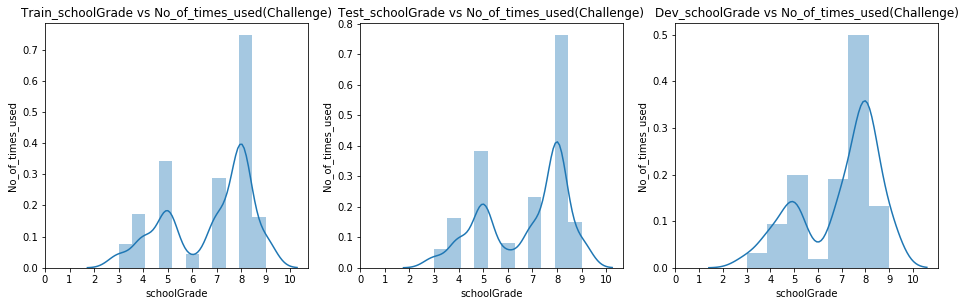

Easy dataset Analysis ...............


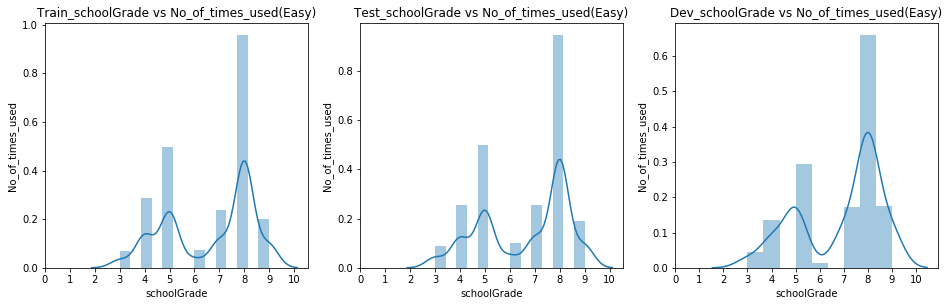

In [68]:
plot_subplot_bar("_multiple_main_challenge[\"schoolGrade\"]","Challenge")

plot_subplot_bar("_multiple_main_easy[\"schoolGrade\"]","Easy")

<h4>1.2 ExamName Analysis</h4>

easy dataset Analysis ...............


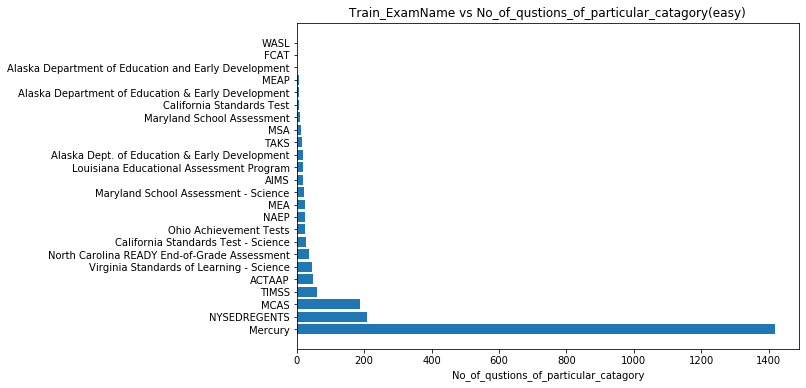

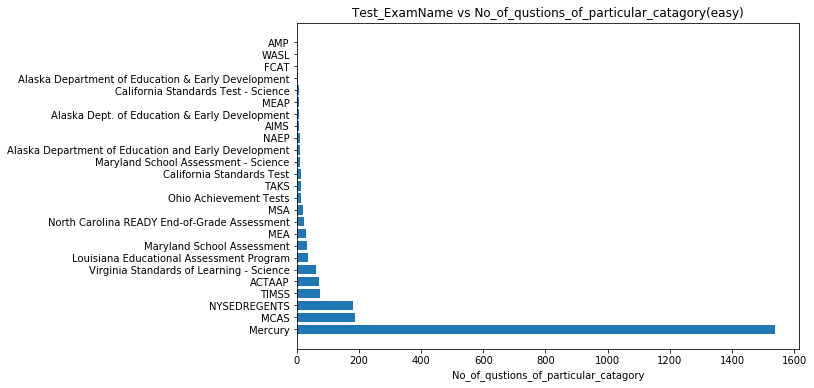

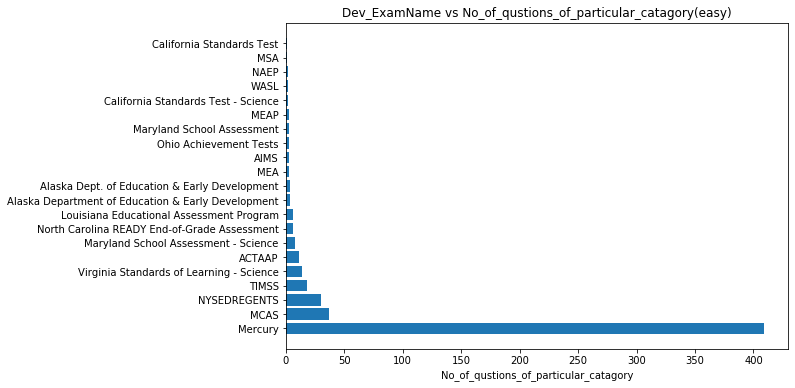

In [93]:
Exam_graph("easy") 

challenge dataset Analysis ...............


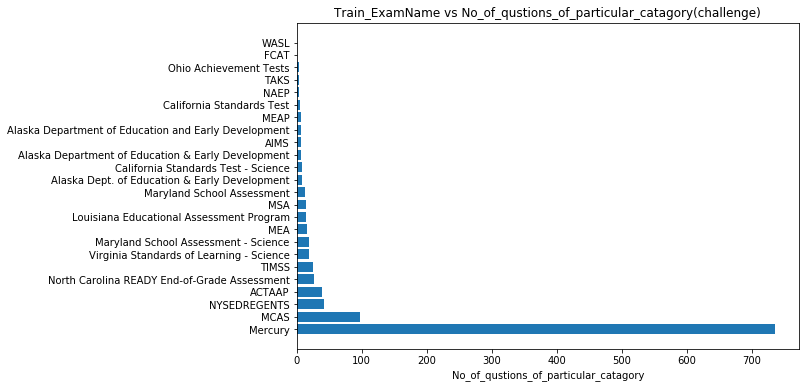

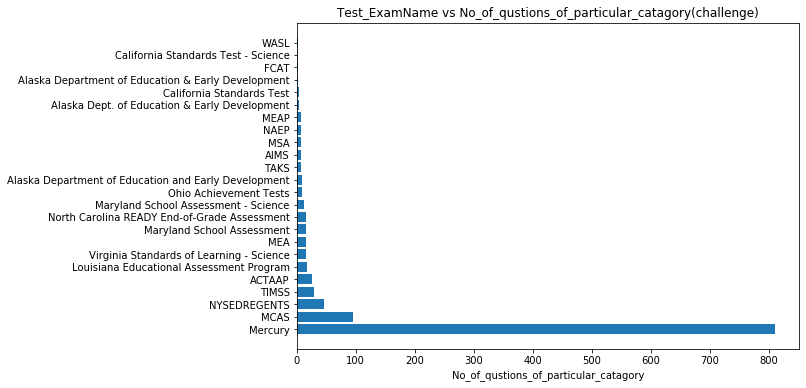

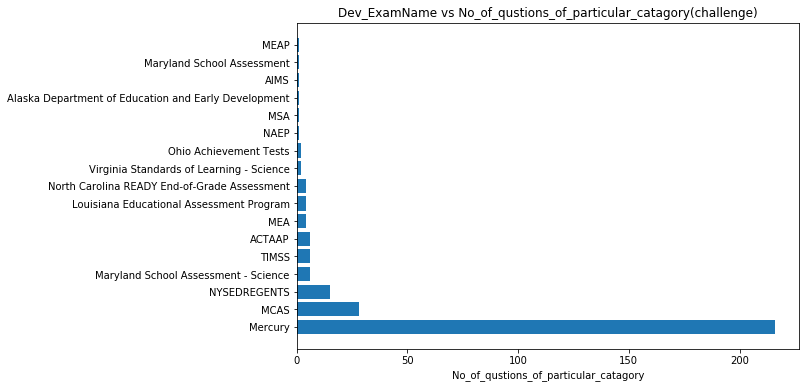

In [94]:
Exam_graph("challenge") 

<h4>1.3 Year_graph</h4>

easy dataset Analysis ...............


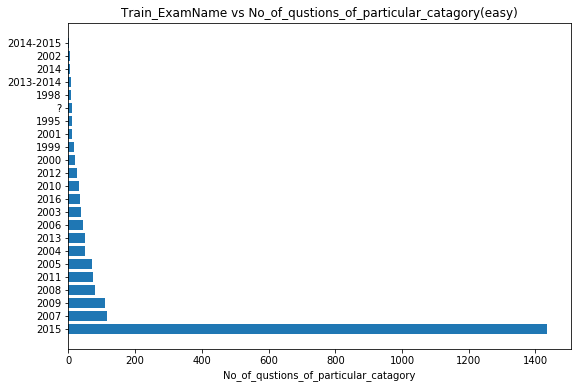

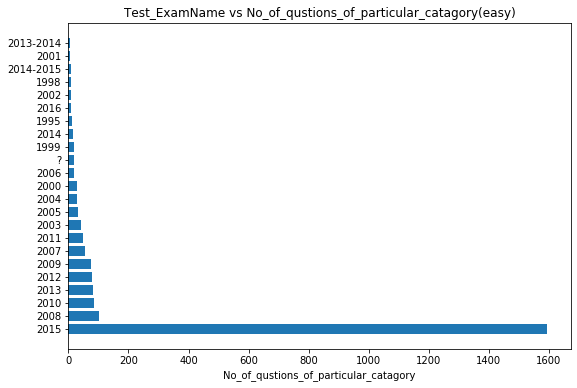

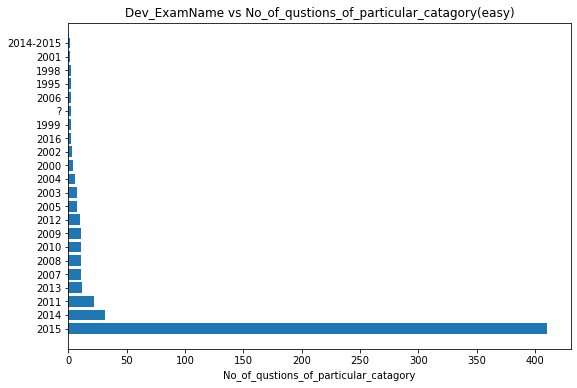

In [95]:
Year_graph("easy") 

challenge dataset Analysis ...............


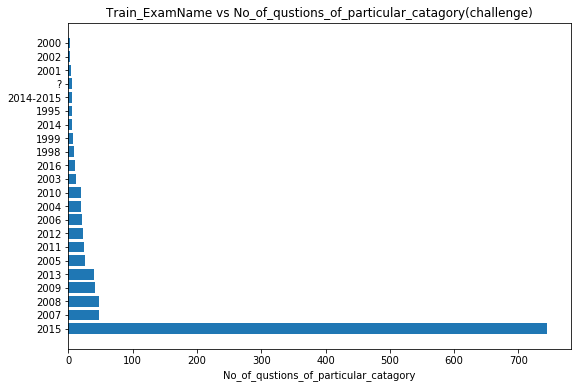

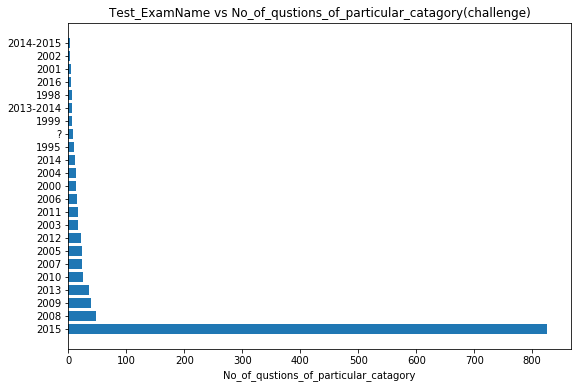

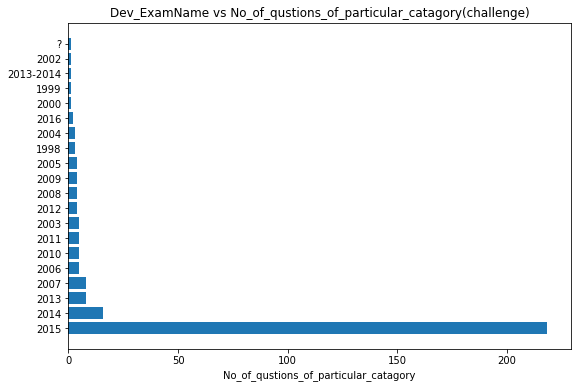

In [96]:
Year_graph("challenge") 

<h4>1.4 Questions</h4>

In [98]:
Train_multiple_main_challenge["question"][5]

'Which land form is the result of the constructive force of a glacier? (A) valleys carved by a moving glacier (B) piles of rocks deposited by a melting glacier (C) grooves created in a granite surface by a glacier (D) bedrock hills roughened by the passing of a glacier'

In [101]:
Train_multiple_main_challenge["question"][50]

'Scientists who disagree with the results of an experiment should (A) change the experiment. (B) keep their opinions to themselves. (C) find out what other scientists think about the results. (D) repeat the experiment several times and compare results.'

In [105]:
Train_multiple_main_challenge.shape

(1119, 12)

In [6]:
easy_list = question_clean("easy") 
Train_multiple_main_easy['question'] = easy_list[0]
Test_multiple_main_easy['question'] = easy_list[1]
Dev_multiple_main_easy['question'] = easy_list[2]


challenge_list = question_clean("challenge") 
Train_multiple_main_challenge['question'] = challenge_list[0]
Test_multiple_main_challenge['question'] = challenge_list[1]
Dev_multiple_main_challenge['question'] = challenge_list[2]

Total question filtered in set: Train dataset : easy 570
####################################################################################################
What form of energy makes a compass needle point north?(A) electrical (B) heat (C) light (D) magnetic
Question not filtered !!!
......
.........
Fixing the issue......
Fixed question is:  What form of energy makes a compass needle point north
Total question filtered in set: Test dataset : easy 2946
####################################################################################################
Total question filtered in set: Dev dataset : easy 3516
####################################################################################################
Total question filtered in set: Train dataset : challenge 1119
####################################################################################################
Total question filtered in set: Test dataset : challenge 2291
##########################################################

In [7]:
from collections import Counter
length_of_question = []
for question_ in Train_multiple_answers_challenge['question']:
    length_of_question.append(len([i for i in question_.split()]))
sorted_x = sorted(dict(Counter(length_of_question)).items(), key=lambda kv: kv[0])

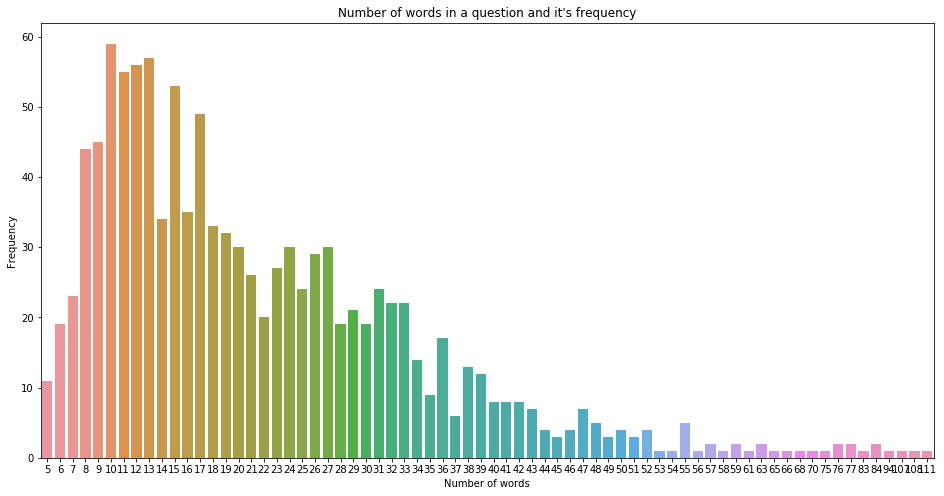

In [8]:
plt.figure(figsize=(16,8))
plt.title("Number of words in a question and it's frequency")
sns.barplot([i[0] for i in sorted_x],[i[1] for i in sorted_x])
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

easy dataset Analysis ...............
challenge dataset Analysis ...............


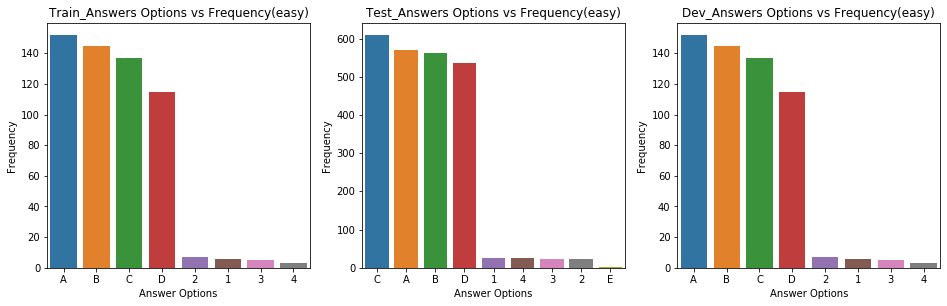

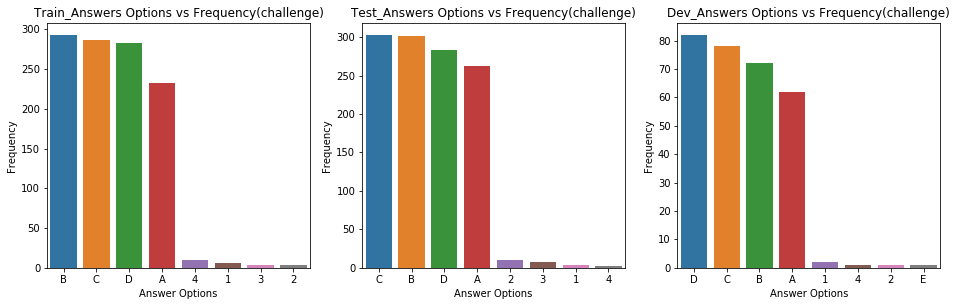

In [62]:
Answer_graph("easy")
Answer_graph("challenge")

In [50]:
Train_multiple_main_challenge.head(2)

,questionID,originalQuestionID,totalPossiblePoint,AnswerKey,isMultipleChoiceQuestion,includesDiagram,examName,schoolGrade,year,question,subject,category,A,B,C,D,E
0,Mercury_SC_415702,415702,1,A,1,0,Mercury,3,2015,George wants to warm his hands quickly by rubb...,NaN,Train,a leg muscle relaxing after exercise,a bacterial population in the bloodstream,several viral particles on the skin,carbohydrates being digested in the stomach,NaN
1,MCAS_2009_5_6516,6516,1,B,1,0,MCAS,5,2009,Which of the following statements best explain...,NaN,Train,carbon dioxide,food,protection,water,NaN


<h3>2. Data Cleaning</h3>

<h4>2.1 Corpus Cleaning</h4>

In [9]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


In [11]:
import re
proceesed_data = process_questions("challenge")  
Train_multiple_main_challenge['question'] = proceesed_data[0]
Test_multiple_main_challenge['question'] = proceesed_data[1]
Dev_multiple_main_challenge['question'] = proceesed_data[2]

#################################################3

proceesed_data = process_questions("easy")  
Train_multiple_main_easy['question'] = proceesed_data[0]
Test_multiple_main_easy['question'] = proceesed_data[1]
Dev_multiple_main_easy['question'] = proceesed_data[2]

In [61]:
Corpous_processed = Corpous_Processing(Sampled_Corpous_data)
print("Corpous processing done....")
processed_word_main = ""
question_list = []
count = 0
for question in tqdm(Corpous_processed):
    count+=1
    processed_word_main = ""
    for word in question.split():
        processed_word = WordNetLemmatizer().lemmatize(word,'v')
        processed_word = processed_word+" "
        processed_word_main += processed_word
    processed_word_main = processed_word_main.strip()    
    question_list.append(processed_word_main) 

In [106]:
#using TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
Corpous_tfisf_clf = TfidfVectorizer(lowercase=True,ngram_range=(1, 3), max_df=500, min_df=2, max_features=10000)
Corpous_vector_form = Corpous_tfisf_clf.fit_transform(question_list)

In [107]:
Corpous_vector_form.shape

(10000, 10000)

<h4>Performance Matrix</h4>

<h4>1. Random Guess Base Reference Model</h4>

In [43]:
# Challenge Test Dataset
challenge_random = (Test_multiple_answers_challenge.shape[0]*.25)/Test_multiple_answers_challenge.shape[0]*100
easy_random = (Test_multiple_answers_easy.shape[0]*.25)/Test_multiple_answers_easy.shape[0]*100
print("Challenge Dataset Random Score : ",challenge_random)
print("Easy Dataset Random Score : ",easy_random)

Challenge Dataset Random Score :  25.0
Easy Dataset Random Score :  25.0


<h4>2. Information Retireval</h4>

In [65]:
Train_multiple_main_challenge.head(2)

,questionID,originalQuestionID,totalPossiblePoint,AnswerKey,isMultipleChoiceQuestion,includesDiagram,examName,schoolGrade,year,question,subject,category,A,B,C,D,E
0,Mercury_SC_415702,415702,1,A,1,0,Mercury,3,2015,george wants warm hands quickly rubbing skin s...,NaN,Train,a leg muscle relaxing after exercise,a bacterial population in the bloodstream,several viral particles on the skin,carbohydrates being digested in the stomach,NaN
1,MCAS_2009_5_6516,6516,1,B,1,0,MCAS,5,2009,following statements best explains magnets usu...,NaN,Train,carbon dioxide,food,protection,water,NaN


In [93]:
#using TFIDF
questions_tfidf_clf = TfidfVectorizer(lowercase=True,ngram_range=(1, 3), max_df=500, min_df=1, max_features=10000)
question_vector_form = questions_tfidf_clf.fit_transform(Train_multiple_main_challenge["question"])

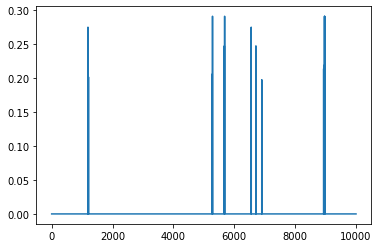

In [111]:
plt.plot(question_vector_form.toarray()[0])

In [ ]:
question_vector_form.toarray()[0]

In [114]:
from sklearn.metrics.pairwise import cosine_similarity

In [131]:
Cos_sim = cosine_similarity(question_vector_form.toarray(),Corpous_vector_form)
Cos_sim.shape

(1119, 10000)

In [146]:
cos=pd.DataFrame(Cos_sim[0],columns=["Cos_sim"])
cos["Index"] = [i for i in range(10000)]
sorted(cos["Cos_sim"])[::-1]

[0.18351728296792857,
 0.17525940497211137,
 0.17409908539719696,
 0.16185235321066208,
 0.15649046367364125,
 0.14700710867617633,
 0.1459312917330561,
 0.14552982482418927,
 0.1442970462118389,
 0.12511781828828708,
 0.12207190992404898,
 0.11887175580834826,
 0.11859793855596419,
 0.11742486604171012,
 0.11671391202897045,
 0.11550834670472493,
 0.11471286959353527,
 0.11171516687568728,
 0.10998818329791589,
 0.10988384860021735,
 0.10856688994642641,
 0.10711912967164493,
 0.10566846517534932,
 0.10526677941992946,
 0.10364341032161226,
 0.10347814525405281,
 0.10338144240956126,
 0.10284783241658904,
 0.10086445127690005,
 0.10068508204559347,
 0.09915623194996538,
 0.09834135384582181,
 0.09715494581871058,
 0.0956836502818994,
 0.09340168487182454,
 0.093362300521668,
 0.09186242045991497,
 0.091431364177719,
 0.09121542562449075,
 0.08988722071923907,
 0.08928001515491867,
 0.08868056403225691,
 0.08865524856043507,
 0.08794847155346099,
 0.0878879557923528,
 0.086985547772634

In [147]:
for i,v in enumerate(cos["Cos_sim"]):
    if(v in [0.18351728296792857,
 0.17525940497211137,
 0.17409908539719696,
 0.16185235321066208,
 0.15649046367364125,
 0.14700710867617633,
 0.1459312917330561,
 0.14552982482418927,
 0.1442970462118389,
 0.12511781828828708,
 0.12207190992404898,
 0.11887175580834826,
 0.11859793855596419,
 0.11742486604171012,]):
        print(i)
        print(v)

285
0.17525940497211137
822
0.15649046367364125
852
0.14700710867617633
1663
0.14552982482418927
2776
0.12511781828828708
3796
0.17409908539719696
4009
0.1442970462118389
4298
0.18351728296792857
5359
0.1459312917330561
6013
0.11859793855596419
6512
0.11887175580834826
7142
0.16185235321066208
7396
0.12207190992404898
9332
0.11742486604171012


In [143]:
Train_multiple_main_challenge["question"][0]

'george wants warm hands quickly rubbing skin surface produce heat'

In [144]:
Train_multiple_main_challenge.head(2)

,questionID,originalQuestionID,totalPossiblePoint,AnswerKey,isMultipleChoiceQuestion,includesDiagram,examName,schoolGrade,year,question,subject,category,A,B,C,D,E
0,Mercury_SC_415702,415702,1,A,1,0,Mercury,3,2015,george wants warm hands quickly rubbing skin s...,NaN,Train,a leg muscle relaxing after exercise,a bacterial population in the bloodstream,several viral particles on the skin,carbohydrates being digested in the stomach,NaN
1,MCAS_2009_5_6516,6516,1,B,1,0,MCAS,5,2009,following statements best explains magnets usu...,NaN,Train,carbon dioxide,food,protection,water,NaN


In [148]:
Corpous_processed[
285]

'stay consistent nighttime training pants absorbency rely help potty train night'

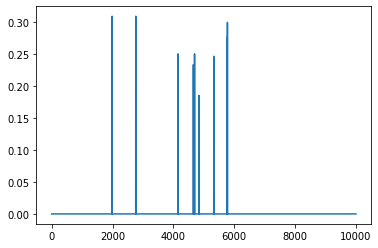

In [113]:
Corpous_vector_form.toarray()[0]